In [2]:
# Section 0: Install Required Packages
# Run this once at the start of the notebook

!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn --quiet

In [3]:
# Section 1: Setup & Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import os

# Ensure output directories exist
os.makedirs("data/processed", exist_ok=True)

In [11]:
# Section 2: Load Raw Data

fraud_df = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

print("📄 Fraud data shape:", fraud_df.shape)
print("📄 IP-to-country data shape:", ip_df.shape)
fraud_df.head()


📄 Fraud data shape: (151112, 11)
📄 IP-to-country data shape: (138846, 3)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [7]:
# Section 3: Handle Missing Values

print("🔍 Missing values per column:")
print(fraud_df.isnull().sum())

# Drop rows with missing values
fraud_df = fraud_df.dropna()
print("✅ Shape after dropping missing values:", fraud_df.shape)


🔍 Missing values per column:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
✅ Shape after dropping missing values: (151112, 11)


In [8]:
# Section 4: Data Cleaning

# Remove duplicates
fraud_df = fraud_df.drop_duplicates()

# Convert datatypes
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Ensure 'age' is numeric
fraud_df['age'] = pd.to_numeric(fraud_df['age'], errors='coerce')
fraud_df = fraud_df.dropna()

print("✅ Cleaned data shape:", fraud_df.shape)
fraud_df.dtypes


✅ Cleaned data shape: (151112, 11)


user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

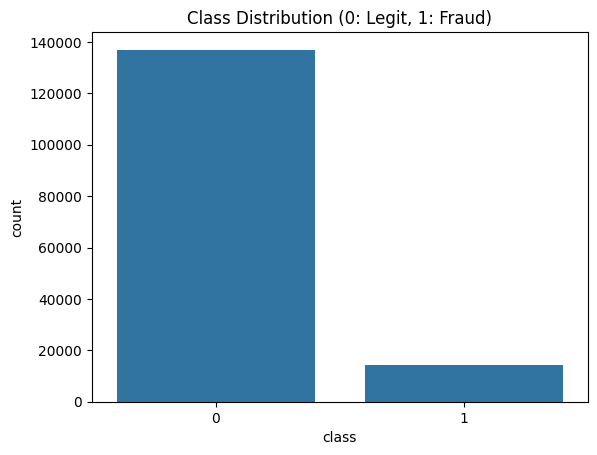

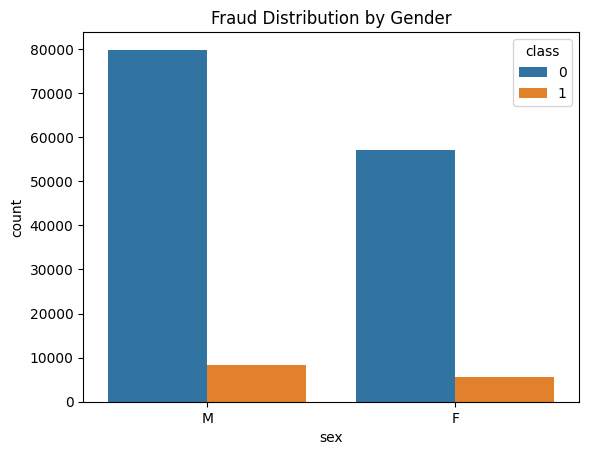

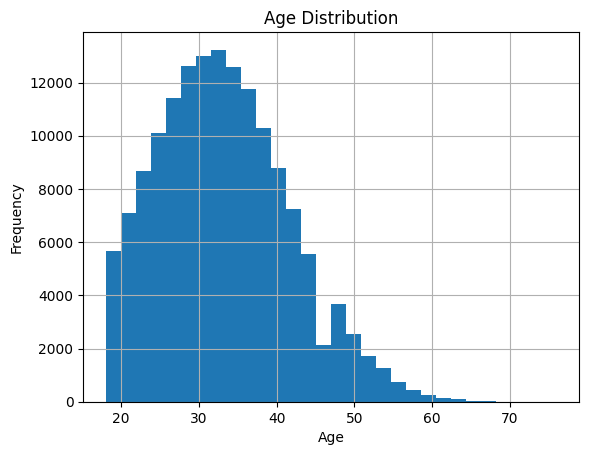

In [9]:
# Section 5: Exploratory Data Analysis

# Class distribution
sns.countplot(data=fraud_df, x='class')
plt.title("Class Distribution (0: Legit, 1: Fraud)")
plt.show()

# Fraud by gender
sns.countplot(data=fraud_df, x='sex', hue='class')
plt.title("Fraud Distribution by Gender")
plt.show()

# Age distribution
fraud_df['age'].hist(bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Section 6: Merge IP to Country

def convert_ip_to_int(ip_str):
    parts = list(map(int, ip_str.split(".")))
    return (16777216 * parts[0]) + (65536 * parts[1]) + (256 * parts[2]) + parts[3]

fraud_df['ip_int'] = fraud_df['ip_address'].apply(convert_ip_to_int)
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].apply(convert_ip_to_int)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].apply(convert_ip_to_int)

ip_df_sorted = ip_df.sort_values(by='lower_bound_ip_address')

def find_country(ip):
    match = ip_df_sorted[(ip_df_sorted['lower_bound_ip_address'] <= ip) &
                         (ip_df_sorted['upper_bound_ip_address'] >= ip)]
    if not match.empty:
        return match.iloc[0]['country']
    return "Unknown"

fraud_df['country'] = fraud_df['ip_int'].apply(find_country)
fraud_df[['ip_address', 'country']].head()


✅ IP to country mapping completed!


,ip_address,ip_int,country
0,7.327584e+08,732758368,Japan
1,3.503114e+08,350311387,United States
2,2.621474e+09,2621473820,United States
3,3.840542e+09,3840542443,Unknown
4,4.155831e+08,415583117,United States


🌍 Country Distribution:
country
United States        58049
Unknown              21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: count, dtype: int64

📊 Countries identified: 182
Unknown countries: 21966


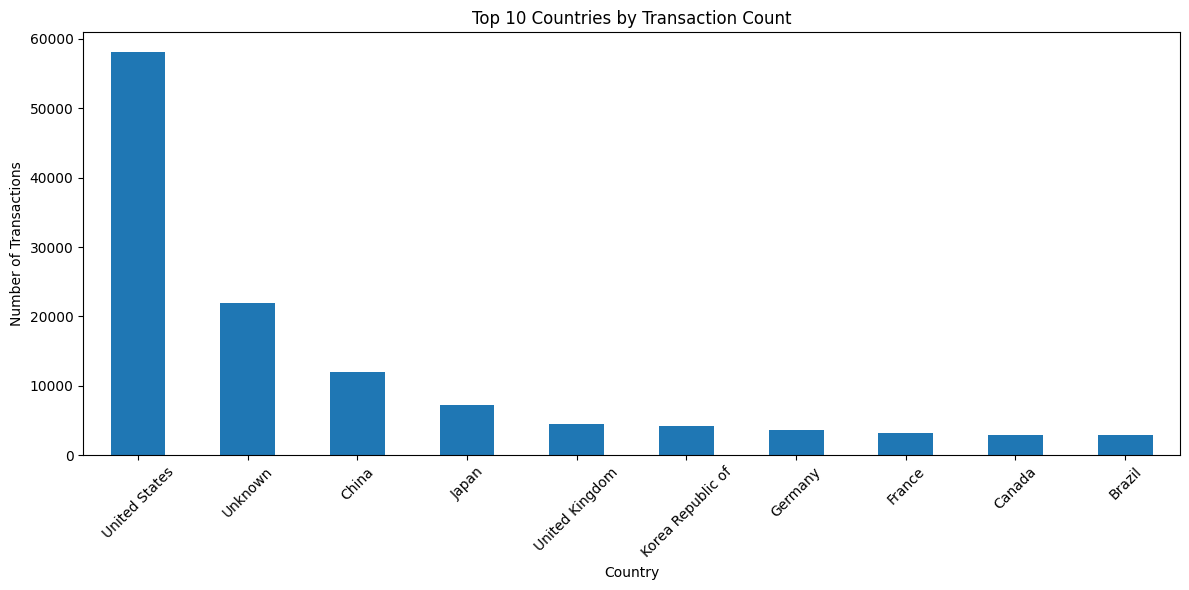

In [14]:
# Country distribution analysis
print("🌍 Country Distribution:")
country_counts = fraud_df['country'].value_counts()
print(country_counts.head(10))

print(f"\n📊 Countries identified: {len(country_counts)}")
print(f"Unknown countries: {(fraud_df['country'] == 'Unknown').sum()}")

# Visualize top countries
plt.figure(figsize=(12, 6))
country_counts.head(10).plot(kind='bar')
plt.title('Top 10 Countries by Transaction Count')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Section 7: Feature Engineering

# Check and fix datetime columns first
print("🔍 Checking datetime columns...")
print(f"signup_time dtype: {fraud_df['signup_time'].dtype}")
print(f"purchase_time dtype: {fraud_df['purchase_time'].dtype}")

# Convert to datetime if not already
if fraud_df['signup_time'].dtype == 'object':
    fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'], errors='coerce')
if fraud_df['purchase_time'].dtype == 'object':
    fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'], errors='coerce')

# Remove any rows where datetime conversion failed
fraud_df = fraud_df.dropna(subset=['signup_time', 'purchase_time'])

print("✅ Datetime conversion completed!")
print(f"signup_time dtype: {fraud_df['signup_time'].dtype}")
print(f"purchase_time dtype: {fraud_df['purchase_time'].dtype}")

# Create time-based features
fraud_df['signup_hour'] = fraud_df['signup_time'].dt.hour
fraud_df['purchase_hour'] = fraud_df['purchase_time'].dt.hour
fraud_df['signup_day_of_week'] = fraud_df['signup_time'].dt.dayofweek
fraud_df['purchase_day_of_week'] = fraud_df['purchase_time'].dt.dayofweek

# Time difference between signup and purchase
fraud_df['time_diff_hours'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600

# Age groups
fraud_df['age_group'] = pd.cut(fraud_df['age'], 
                               bins=[0, 25, 35, 50, 65, 100], 
                               labels=['18-25', '26-35', '36-50', '51-65', '65+'])

# Purchase value categories
fraud_df['purchase_category'] = pd.cut(fraud_df['purchase_value'], 
                                       bins=[0, 50, 100, 200, 500, float('inf')], 
                                       labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

print("✅ Feature engineering completed!")
print(f"📊 Dataset shape after feature engineering: {fraud_df.shape}")
print(f"📊 New features created: {['signup_hour', 'purchase_hour', 'signup_day_of_week', 'purchase_day_of_week', 'time_diff_hours', 'age_group', 'purchase_category']}")

# Display sample of new features
fraud_df[['signup_hour', 'purchase_hour', 'time_diff_hours', 'age_group', 'purchase_category', 'class']].head()

🔍 Checking datetime columns...
signup_time dtype: datetime64[ns]
purchase_time dtype: datetime64[ns]
✅ Datetime conversion completed!
signup_time dtype: datetime64[ns]
purchase_time dtype: datetime64[ns]
✅ Feature engineering completed!
📊 Dataset shape after feature engineering: (151112, 20)
📊 New features created: ['signup_hour', 'purchase_hour', 'signup_day_of_week', 'purchase_day_of_week', 'time_diff_hours', 'age_group', 'purchase_category']


,signup_hour,purchase_hour,time_diff_hours,age_group,purchase_category,class
0,22,2,1251.856111,36-50,Very Low,0
1,20,1,4.984444,51-65,Very Low,0
2,18,18,0.000278,51-65,Very Low,1
3,21,13,136.690278,36-50,Very Low,0
4,7,18,1211.516944,36-50,Very Low,0


In [18]:
# Section 8: Data Transformation (Encoding & Scaling)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Create a copy for transformation
processed_df = fraud_df.copy()

# Initialize encoders
label_encoders = {}

# Encode categorical variables
categorical_columns = ['sex', 'age_group', 'purchase_category', 'country']

print("🔄 Encoding categorical variables...")
for col in categorical_columns:
    if col in processed_df.columns:
        le = LabelEncoder()
        processed_df[col + '_encoded'] = le.fit_transform(processed_df[col].astype(str))
        label_encoders[col] = le
        print(f"✅ Encoded {col}: {len(le.classes_)} unique values")

# Select features for modeling
feature_columns = [
    'user_id', 'age', 'purchase_value', 'ip_int',
    'signup_hour', 'purchase_hour', 'signup_day_of_week', 'purchase_day_of_week',
    'time_diff_hours', 'sex_encoded', 'age_group_encoded', 
    'purchase_category_encoded', 'country_encoded'
]

# Remove any columns that don't exist
feature_columns = [col for col in feature_columns if col in processed_df.columns]

X = processed_df[feature_columns]
y = processed_df['class']

print(f"📊 Features selected: {len(feature_columns)}")
print(f"📊 Feature names: {feature_columns}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['age', 'purchase_value', 'ip_int', 'time_diff_hours']
numerical_features = [col for col in numerical_features if col in X.columns]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("✅ Data transformation completed!")
print(f"📊 Training set shape: {X_train_scaled.shape}")
print(f"📊 Test set shape: {X_test_scaled.shape}")
print(f"📊 Class distribution in training set:")
print(y_train.value_counts(normalize=True))

🔄 Encoding categorical variables...
✅ Encoded sex: 2 unique values
✅ Encoded age_group: 5 unique values
✅ Encoded purchase_category: 3 unique values
✅ Encoded country: 182 unique values
📊 Features selected: 13
📊 Feature names: ['user_id', 'age', 'purchase_value', 'ip_int', 'signup_hour', 'purchase_hour', 'signup_day_of_week', 'purchase_day_of_week', 'time_diff_hours', 'sex_encoded', 'age_group_encoded', 'purchase_category_encoded', 'country_encoded']
✅ Data transformation completed!
📊 Training set shape: (120889, 13)
📊 Test set shape: (30223, 13)
📊 Class distribution in training set:
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64


📊 Original class distribution:
class
0    109568
1     11321
Name: count, dtype: int64

Class proportions:
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64

📊 After SMOTE balancing:
class
0    109568
1    109568
Name: count, dtype: int64

Balanced class proportions:
class
0    0.5
1    0.5
Name: proportion, dtype: float64

✅ Training set balanced from 120889 to 219136 samples


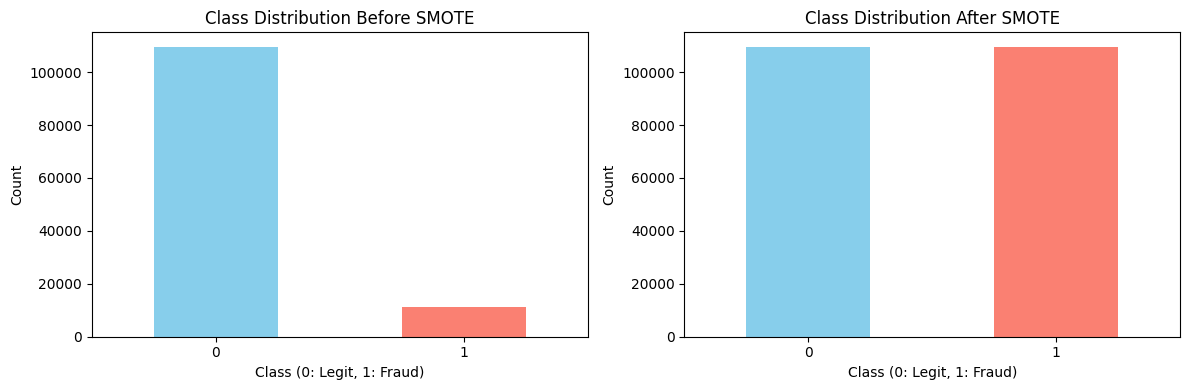

In [22]:
# Section 9: Class Imbalance Handling

print("📊 Original class distribution:")
print(y_train.value_counts())
print("\nClass proportions:")
print(y_train.value_counts(normalize=True))

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\n📊 After SMOTE balancing:")
print(pd.Series(y_train_balanced).value_counts())
print("\nBalanced class proportions:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

print(f"\n✅ Training set balanced from {X_train_scaled.shape[0]} to {X_train_balanced.shape[0]} samples")

# Visualize class distribution before and after SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Before SMOTE
y_train.value_counts().plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Class Distribution Before SMOTE')
ax1.set_xlabel('Class (0: Legit, 1: Fraud)')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# After SMOTE
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=ax2, color=['skyblue', 'salmon'])
ax2.set_title('Class Distribution After SMOTE')
ax2.set_xlabel('Class (0: Legit, 1: Fraud)')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [23]:
# Section 10: Save Preprocessed Data

import pickle
import json

# Create processed data directory if it doesn't exist
os.makedirs("../data/processed", exist_ok=True)

print("💾 Saving preprocessed data...")

# Save the cleaned and feature-engineered dataframe
fraud_df.to_csv("../data/processed/fraud_data_cleaned.csv", index=False)
print("✅ Saved cleaned fraud data")

# Save processed datasets for modeling
X_train_scaled.to_csv("../data/processed/X_train_scaled.csv", index=False)
X_test_scaled.to_csv("../data/processed/X_test_scaled.csv", index=False)
y_train.to_csv("../data/processed/y_train.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

# Save balanced training data
pd.DataFrame(X_train_balanced, columns=X_train_scaled.columns).to_csv("../data/processed/X_train_balanced.csv", index=False)
pd.Series(y_train_balanced, name='class').to_csv("../data/processed/y_train_balanced.csv", index=False)

print("✅ Saved training and test sets")

# Save preprocessing objects
with open("../data/processed/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("../data/processed/label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

print("✅ Saved preprocessing objects (scaler, encoders)")

# Save feature information
feature_info = {
    "feature_columns": feature_columns,
    "numerical_features": numerical_features,
    "categorical_columns": categorical_columns,
    "total_features": len(feature_columns)
}

with open("../data/processed/feature_info.json", "w") as f:
    json.dump(feature_info, f, indent=2)

print("✅ Saved feature information")

# Summary of saved files
print("\n📋 Summary of preprocessed data:")
print(f"   • Original dataset shape: {fraud_df.shape}")
print(f"   • Training set shape: {X_train_scaled.shape}")
print(f"   • Test set shape: {X_test_scaled.shape}")
print(f"   • Balanced training set shape: {X_train_balanced.shape}")
print(f"   • Number of features: {len(feature_columns)}")
print(f"   • Class distribution (original): {dict(y_train.value_counts())}")
print(f"   • Class distribution (balanced): {dict(pd.Series(y_train_balanced).value_counts())}")

print("\n🎉 Data preprocessing completed successfully!")
print("📁 All processed files saved to: ../data/processed/")
print("\n📋 Files created:")
print("   • fraud_data_cleaned.csv - Complete cleaned dataset")
print("   • X_train_scaled.csv, y_train.csv - Training data")
print("   • X_test_scaled.csv, y_test.csv - Test data")
print("   • X_train_balanced.csv, y_train_balanced.csv - Balanced training data")
print("   • scaler.pkl - StandardScaler object")
print("   • label_encoders.pkl - Label encoders for categorical variables")
print("   • feature_info.json - Feature metadata")

💾 Saving preprocessed data...
✅ Saved cleaned fraud data
✅ Saved training and test sets
✅ Saved preprocessing objects (scaler, encoders)
✅ Saved feature information

📋 Summary of preprocessed data:
   • Original dataset shape: (151112, 20)
   • Training set shape: (120889, 13)
   • Test set shape: (30223, 13)
   • Balanced training set shape: (219136, 13)
   • Number of features: 13
   • Class distribution (original): {0: np.int64(109568), 1: np.int64(11321)}
   • Class distribution (balanced): {0: np.int64(109568), 1: np.int64(109568)}

🎉 Data preprocessing completed successfully!
📁 All processed files saved to: ../data/processed/

📋 Files created:
   • fraud_data_cleaned.csv - Complete cleaned dataset
   • X_train_scaled.csv, y_train.csv - Training data
   • X_test_scaled.csv, y_test.csv - Test data
   • X_train_balanced.csv, y_train_balanced.csv - Balanced training data
   • scaler.pkl - StandardScaler object
   • label_encoders.pkl - Label encoders for categorical variables
   • fe